# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# config['bs'] = 2
# config['bptt'] = 1024
# config['n_layers'] = 4
# config['n_heads'] = 4
# config['dec_layers'] = 2

In [11]:
# config['n_layers'] = 8
# config['dec_layers'] = 0
config['n_layers'] = 4
config['dec_layers'] = 6
config['mem_len'] = 512
config['rand_bptt'] = False

In [12]:
config

{'ctx_len': 150,
 'n_layers': 4,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 139),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 274,
 'dec_layers': 6}

In [13]:
base_path = Path('../../data/midi/v15/')

In [14]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## BERT Dataloading

In [15]:
ns_dl_tfms = [mask_tfm, next_sentence_tfm]
ns_config = config.copy()
ns_config['bs'] *= 2
ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                          y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

In [16]:
xb,yb = ns_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256])]

## S2S Dataloading

In [24]:
s2s_dl_tfms = [s2s_tfm]
s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                           preloader_cls=S2SPreloader, dl_tfms=s2s_dl_tfms, y_offset=1,
                           shuffle_dl=True, **config)


In [25]:
s2s_data.train_dl.dl.dataset.on_epoch_begin()
s2s_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = s2s_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

In [26]:
xb

[tensor([[  5, 273,   4,  ...,   1,   1,   1],
         [  6, 273,   8,  ...,   1,   1,   1],
         [  5, 273,   4,  ...,   1,   1,   1],
         ...,
         [  5, 273,   8,  ...,   1,   1,   1],
         [  6, 273,   8,  ...,   1,   1,   1],
         [  5, 273,   8,  ...,   1,   1,   1]]),
 tensor([[3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]),
 tensor([[  1,   6, 273,  ...,   1,   1,   1],
         [  1,   5, 273,  ...,   1,   1,   1],
         [  1,   6, 273,  ...,   1,   1,   1],
         ...,
         [  1,   6, 273,  ...,   1,   1,   1],
         [  1,   5, 273,  ...,   1,   1,   1],
         [  1,   6, 273,  ...,   1,   1,   1]])]

In [27]:
yb

[tensor([[1, 1, 8,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 8,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[  6, 273,   8,  ...,   1,   1,   1],
         [  5, 273,   8,  ...,   1,   1,   1],
         [  6, 273,   8,  ...,   1,   1,   1],
         ...,
         [  6, 273,   8,  ...,   1,   1,   1],
         [  5, 273,   8,  ...,   1,   1,   1],
         [  6, 273,   8,  ...,   1,   1,   1]])]

### Load NextWord dataset (Language Model)

In [28]:
nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)

In [29]:
nw_data.train_dl.dl.dataset.on_epoch_begin()
nw_data.train_dl.dl.dataset.on_epoch_end()

In [30]:
xb,yb = nw_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

In [31]:
# xb, yb

In [32]:
yb[1][:,3]

tensor([ 93,  69, 143, 145,   8, 140, 140,  78, 147, 141,  79,  86, 141,  78,
          8, 143])

## Datasets

In [33]:
# datasets = [ns_data, s2s_data, nw_data]
datasets = [s2s_data]

In [34]:
ns_data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f6c01df4e48>, device=device(type='cuda'), tfms=[<function mask_tfm at 0x7f6c01dfac80>, <function next_sentence_tfm at 0x7f6c01dfabf8>], collate_fn=<function data_collate at 0x7f6c0f704158>)

## Load

In [35]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [36]:
loss_func = BertLoss(loss_mult=(1,1,1,1))
# learn = bert_model_learner(datasets[0], config.copy(), 
#                            loss_func=loss_func)

model = get_bert_model(config['vocab_size'], config=config.copy())
learn = MusicLearner(datasets[0], model, config=config, split_func=None, loss_func=loss_func)

False


In [37]:
learn.metrics = [mask_acc, ns_acc, s2s_acc, nw_acc]

In [38]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn, datasets))

In [39]:
[type(c) for c in learn.callbacks]

[src.unilm.BertTrainer]

In [40]:
learn = learn.to_fp16()

### Training

In [41]:
# learn.lr_find(num_it=500)
# learn.recorder.plot()

In [42]:
learn.validate()

[15.590087, tensor(0.1014), tensor(0), tensor(0.), tensor(0)]

In [43]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,mask_acc,ns_acc,s2s_acc,nw_acc,time
0,3.812308,3.999610,0.529667,0.000000,0.582681,0.000000,03:11


KeyboardInterrupt: 

In [34]:
learn.save('sample_train_5')

## Load sample train

In [33]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,mask_acc,ns_acc,s2s_acc,nw_acc,time
0,1.738680,1.834674,1.000000,0.000000,0.552947,0.000000,03:14
1,2.663939,2.413430,0.634356,0.000000,0.000000,0.683441,04:42
2,2.519875,2.618765,0.665114,0.380772,0.000000,0.000000,01:25
3,0.195110,0.491651,1.000000,0.000000,0.878556,0.000000,03:14
4,2.420793,2.326906,0.648173,0.000000,0.000000,0.674752,04:42


In [ ]:
# load_path = base_path/'piano_duet/models/sample_train_5.pth'
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

In [ ]:
# learn.load('sample_train')

## Load existing

In [ ]:
saved_models = get_files(base_path/'models/unilm', recurse=True, extensions=['.pth']); saved_models

In [ ]:
# load_path = saved_models[1]
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

## Prediction

Prediction algo

In [61]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [62]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [63]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [64]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [65]:
xb

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')

In [66]:
# task_type = torch.full_like(xb, TaskType.NextWord.value)

# learn.model.reset()

# res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

# preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

In [70]:
# last = res[-1][0, -1]; last[143]
# idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

In [71]:

def predict_nw(self, xb:Tensor, n_words:int=128):
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy().squeeze()
    yb = torch.ones_like(xb)
    new_idx = []
#     self.mask = False
    self.model.reset()

    for i in progress_bar(range(n_words), leave=True):
#         print(xb)
        task_type = torch.full_like(xb, TaskType.NextWord.value)
        
        # Masking last - bert
#         mask_last = torch.cat((xb, torch.tensor(vocab.mask_idx, device=xb.device).view(1, 1)), dim=-1)
#         res = self.pred_batch(batch=((mask_last,task_type,mask_last),(yb)))[0][0, -1] # task1, task2 - (bs x ts x vocab)
        
        # Next Word
        res = self.pred_batch(batch=((xb,task_type,xb),xb))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

        # Encoder only - nw
#         res = self.pred_batch(batch=((xb,task_type,xb),xb))[0][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / (0.5))

        idx = torch.multinomial(res, 1).item()
    
        new_idx.append(idx)
#         t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
#         xb = torch.cat((xb, t_idx), dim=-1)
        xb = xb.new_tensor([idx])[None]
        
#     self.mask = True
    return np.array(new_idx), seed


In [72]:
# vocab.itos[143]

In [73]:
if xb.shape[0] > 1: xb = xb[0][None]
seed = xb.cpu().numpy().squeeze()
yb = torch.ones_like(xb)
res = learn.pred_batch(batch=((xb, torch.full_like(xb, TaskType.NextWord.value),xb),(yb)))
res[-1][0, -1][141]

tensor(0.0004)

In [74]:
out_s, seed_s = predict_nw(learn, xb, n_words=40)

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')
tensor([[62]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[69]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[8]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[67]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[69]], device='cuda:0')
tensor([[147]], device='cuda:0')
tensor([[67]], device='cuda:0')
tensor([[147]], device='cu

In [75]:
[vocab.itos[i] for i in out_s]

['n53',
 'd8',
 'n60',
 'd8',
 'xxsep',
 'd8',
 'xxsep',
 'd8',
 'xxsep',
 'd8',
 'n58',
 'd8',
 'n60',
 'd8',
 'n58',
 'd8',
 'n53',
 'd8',
 'xxsep',
 'd8',
 'n60',
 'd8',
 'xxsep',
 'd8',
 'n60',
 'd8',
 'xxsep',
 'd8',
 'n60',
 'd8',
 'n58',
 'd8',
 'n57',
 'd8',
 'd8',
 'd8',
 'xxsep',
 'd8',
 'n60',
 'd8']

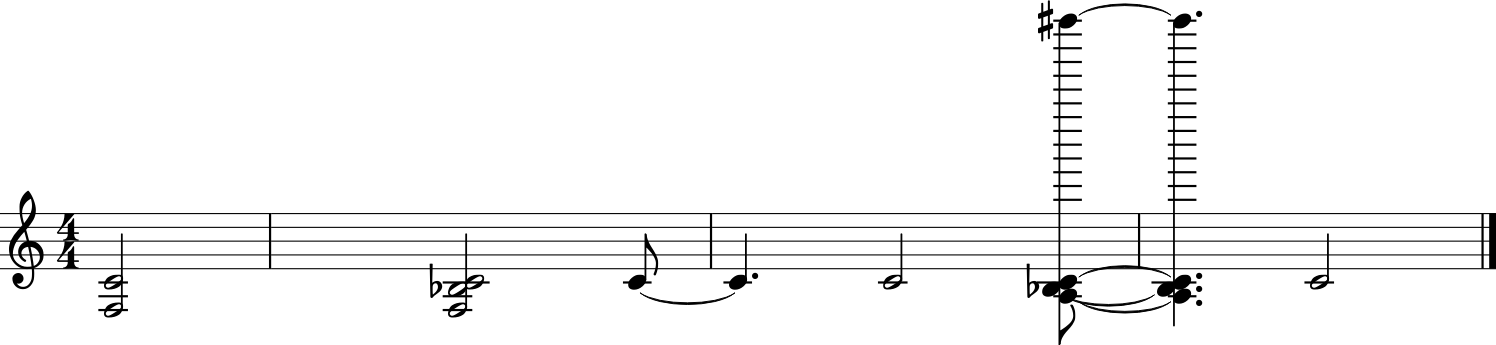

In [76]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()